# Texture-Based Optical Guided Despeckling of SAR Image

In [175]:
import os
# os.environ['JAX_PLATFORM_NAME'] = 'cpu'

import jax
import jax.numpy as jnp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import rasterio

from scripts.texture_descriptor import rgb2gray, rgb2lab
from scripts.despeckle import SARDespeckling

print(jax.devices())

[cuda(id=0)]


In [176]:
sar_despeckling = SARDespeckling()

### Load data

(256, 256, 1) (256, 256, 1) (256, 256, 3)


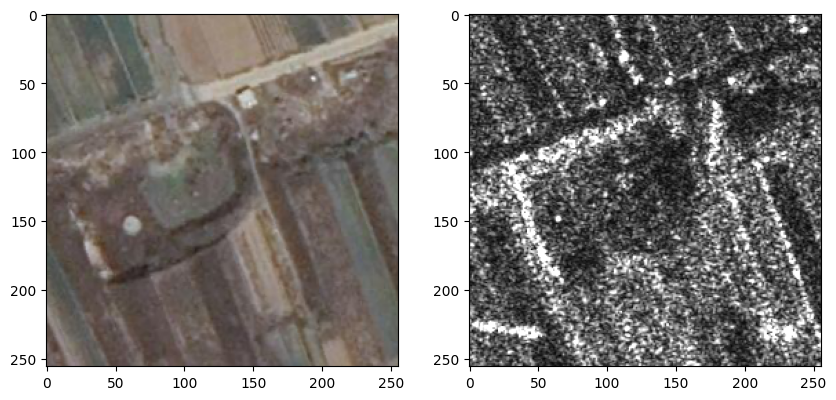

In [177]:
opt = Image.open('/home/nus/workspace/datasets/qxslab/opt/test/images/106.png')
sar = Image.open('/home/nus/workspace/datasets/qxslab/sar/test/images/106.png')

opt_rgb = jnp.array(opt) / 255.0
sar = jnp.array(sar) / 255.0
sar = jnp.expand_dims(sar, axis=-1)  # (H, W, 1)

opt_gray = rgb2gray(opt_rgb)
opt_lab = rgb2lab(opt_rgb)

print(sar.shape, opt_gray.shape, opt_lab.shape)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(opt)
plt.subplot(1, 2, 2)
plt.imshow(sar, cmap='gray')

In [178]:
# def crop(img: np.ndarray, x0: int, y0: int, size: int) -> np.ndarray:
#     """Crop the image to the center with the given size."""
#     return img[y0:y0+size, x0:x0+size]

# path_opt = '/home/nus/workspace/datasets/spacenet9/train/02_optical_train_01.tif'
# path_sar = '/home/nus/workspace/datasets/spacenet9/train/02_sar_train_01.tif'

# with rasterio.open(path_opt) as src:
#     r = src.read(1)
#     g = src.read(2)
#     b = src.read(3)
# data_opt = np.dstack((r, g, b))

# with rasterio.open(path_sar) as src:
#     data_sar = src.read(1)

# x_center_opt, y_center_opt = data_opt.shape[1] // 2, data_opt.shape[0] // 2
# x_center_sar, y_center_sar = data_sar.shape[1] // 2, data_sar.shape[0] // 2

# opt_coords = {
#     'x0': x_center_opt - 500, 
#     'y0': y_center_opt + 500, 
#     'size': 500
# }

# sar_coords = {
#     'x0': x_center_sar - 500, 
#     'y0': y_center_sar + 300, 
#     'size': 500
# }

# opt = crop(data_opt, **opt_coords)
# sar = crop(data_sar, **sar_coords)

# print(opt.shape, sar.shape)

# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(opt)
# plt.subplot(1, 2, 2)
# plt.imshow(sar, cmap='gray')

In [179]:
opt_rgb = jnp.array(opt) / 255.0
sar = jnp.array(sar) / 255.0
# sar = jnp.expand_dims(sar, axis=-1)  # (H, W, 1)

opt_gray = rgb2gray(opt_rgb)
opt_lab = rgb2lab(opt_rgb)

print(sar.shape, opt_gray.shape, opt_lab.shape, opt_rgb.shape)

(256, 256, 1) (256, 256, 1) (256, 256, 3) (256, 256, 3)


### Compute texture descriptor

In [180]:
params_texture_descriptor = {
    'opt': opt_lab,
    'radius': 15
}

S = sar_despeckling._step1_compute_texture_descriptor(**params_texture_descriptor)

INFO:root:Computing texture descriptor...
INFO:root:Texture descriptor computed in 2.21 seconds.


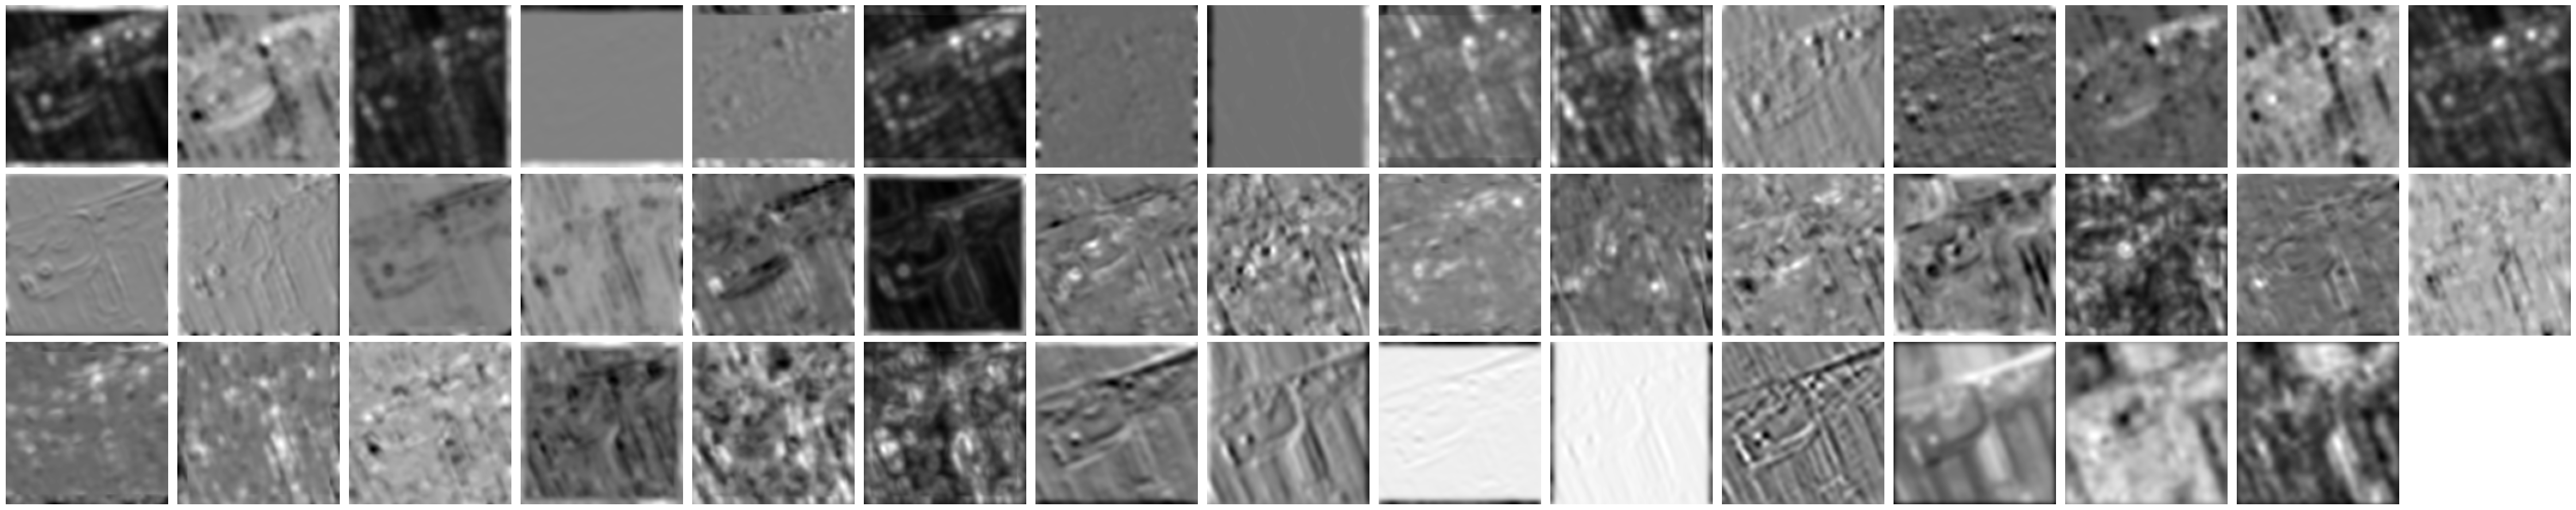

In [181]:
D = S.shape[-1]

N = 15  # Number of columns for plotting
plt.figure(figsize=(N * 3, (D // N + 1) * 3))
for i in range(D):
    plt.subplot(D // N + 1, N, i + 1)
    plt.imshow(S[:,:,i], cmap='gray')
    plt.axis('off')
plt.tight_layout()

### MUBF

In [182]:
params_mubf = {
    'target': S,
    'guides': [opt_gray, sar],  # (H, W, 1)
    'sigma_spatial': 5,
    'sigma_guides': [0.01, 0.001],
    'alpha': 2,
    'n_iterations': 50,
    'n_blocks': 2
}

S_mubf = sar_despeckling._step2_filter_texture_descriptor(**params_mubf)

INFO:root:Filtering texture descriptor with MUBF...
Iterations: 100%|██████████| 50/50 [00:16<00:00,  2.96it/s]
INFO:root:Texture descriptor filtering completed in 16.87 seconds.


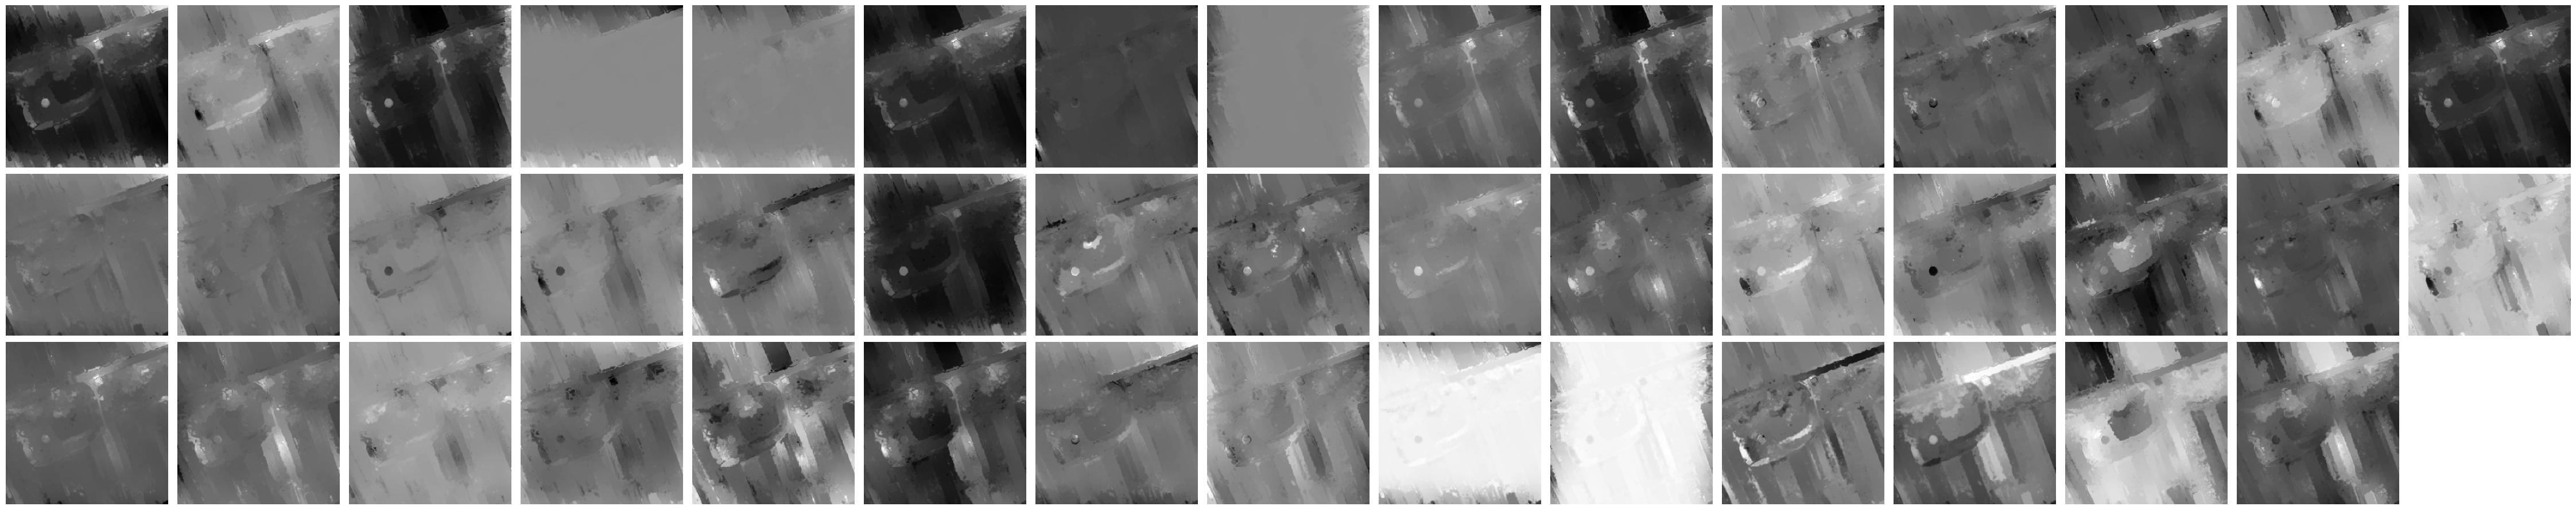

In [183]:
D = S_mubf.shape[-1]

N = 15  # Number of columns for plotting
plt.figure(figsize=(N * 3, (D // N + 1) * 3))
for i in range(D):
    plt.subplot(D // N + 1, N, i + 1)
    plt.imshow(S_mubf[:,:,i], cmap='gray')
    plt.axis('off')
plt.tight_layout()

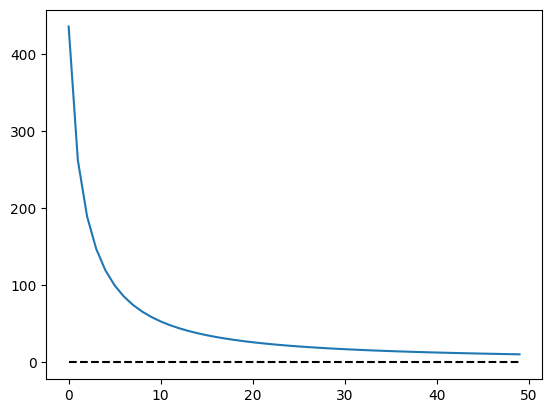

In [184]:
plt.plot(sar_despeckling.error)
plt.plot(np.arange(len(sar_despeckling.error)), np.zeros_like(sar_despeckling.error), 'k--')

### Despeckle

In [185]:
params_despeckling = {
    "sar": sar,
    "descriptor": S_mubf,
    "sigma_distance": 1.5,
    "radius": 20,
    "n_blocks": 20
}

sar_filtered = sar_despeckling._step3_despeckle(**params_despeckling)

INFO:root:Despeckling SAR image...
Despeckling: 100%|██████████| 400/400 [00:03<00:00, 109.08block/s]
INFO:root:Despeckling completed in 3.67 seconds.


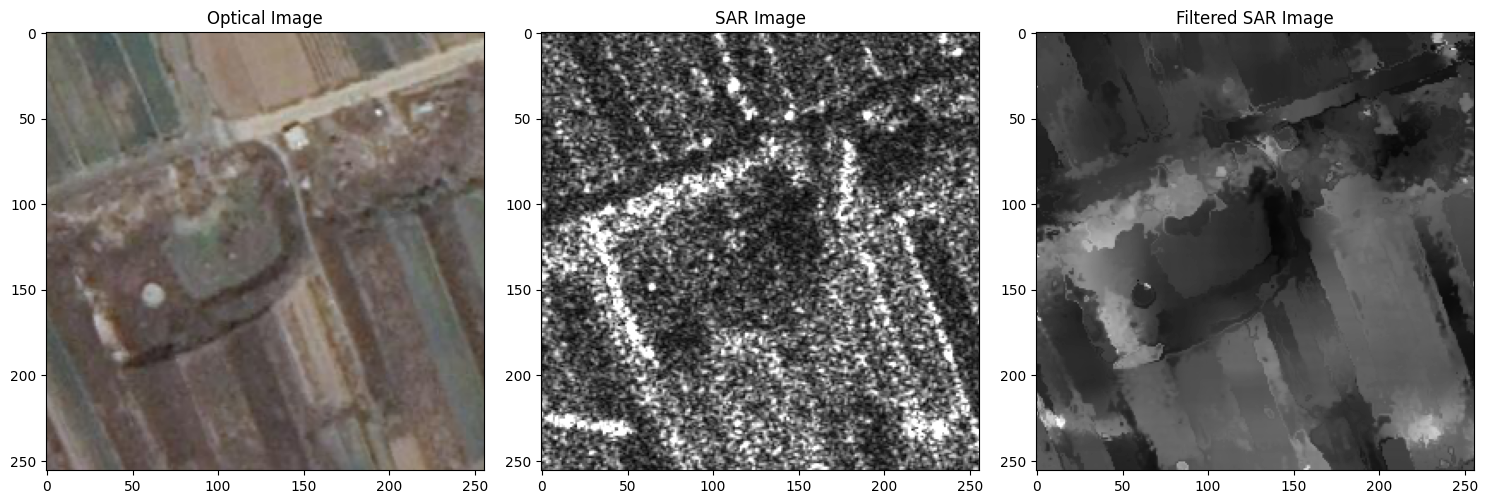

In [186]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(opt)
plt.title('Optical Image')
plt.subplot(1, 3, 2)
plt.imshow(sar, cmap='gray')
plt.title('SAR Image')
plt.subplot(1, 3, 3)
plt.imshow(sar_filtered, cmap='gray')
plt.title('Filtered SAR Image')
plt.tight_layout()

### Test global

In [187]:
# sar_filtered = sar_despeckling.run(sar, 
#                                    opt_rgb,
#                                    radius_descriptor=21,
#                                    sigma_s=5,
#                                    sigma_l_opt=0.1,
#                                    sigma_l_sar=0.1,
#                                    alpha_ubf=1.0,
#                                    n_iter=30,
#                                    sigma_d=1.5,
#                                    radius_despeckling=50,
#                                    n_blocks=10)

In [188]:
# plt.figure(figsize=(15, 5))
# plt.subplot(1, 3, 1)
# plt.imshow(opt)
# plt.title('Optical Image')
# plt.subplot(1, 3, 2)
# plt.imshow(sar, cmap='gray')
# plt.title('SAR Image')
# plt.subplot(1, 3, 3)
# plt.imshow(sar_filtered, cmap='gray')
# plt.title('Filtered SAR Image')
# plt.tight_layout()

In [189]:
# plt.plot(sar_despeckling.error)